# Import necessary python packages

In [1]:
import os

from rdkit.Chem import AllChem
import py3Dmol

from importlib_resources import files

# Load packages from silc

In [2]:
import silc.util as util
from silc.dock import dock

# Load the receptor, i.e. the $\gamma$-cyclodextrin

In [3]:
receptor = AllChem.MolFromPDBFile(str(files('silc.data.receptor').joinpath('GCDOH.pdbqt')))
receptor_block = AllChem.MolToMolBlock(receptor)

# Some example motifs

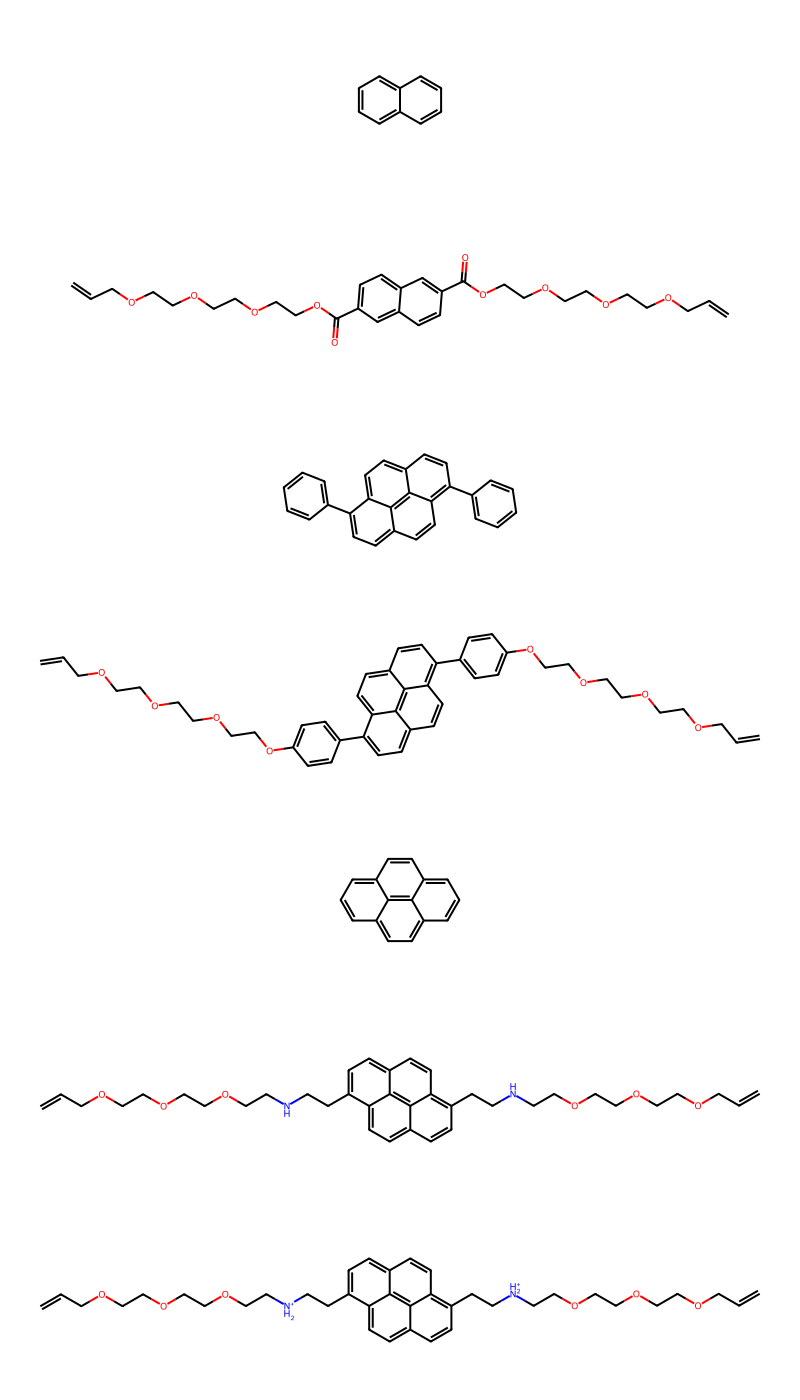

In [4]:
### motif1: naphthaleneCOOEO with CC=C chain end
### motif2: diphenylpyreneEO with CC=C chain end
### motif3: diphenylpyreneCNEO with CC=C chain end
### motif4: diphenylpyreneCNEO with CC=C chain end and N protonated
motifA_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "OC(=O)c1ccc2cc(ccc2c1)C(=O)O" + "CCO"*nEO + "CC=C"
motifB_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "Oc6ccc(c2ccc3ccc5c(c1ccc(O" + "CCO"*nEO + "CC=C)cc1)ccc4ccc2c3c45)cc6"
motifC_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "NCC(c2ccc3ccc5c(CCN" + "CCO"*nEO + "CC=C)ccc4ccc2c3c45)"
motifD_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "[NH2+]CC(c2ccc3ccc5c(CC[NH2+]" + "CCO"*nEO + "CC=C)ccc4ccc2c3c45)"

naphthalene = "c1ccc2ccccc2c1"
diphenylpyrene = "c6ccc(c2ccc3ccc5c(c1ccccc1)ccc4ccc2c3c45)cc6"
pyrene = "c2ccc3ccc5cccc4ccc2c3c45"

nEO = 3
core1 = AllChem.MolFromSmiles(naphthalene)
core2 = AllChem.MolFromSmiles(diphenylpyrene)
core3 = AllChem.MolFromSmiles(pyrene)
motifA = AllChem.MolFromSmiles(motifA_smiles(nEO))
motifB = AllChem.MolFromSmiles(motifB_smiles(nEO))
motifC = AllChem.MolFromSmiles(motifC_smiles(nEO))
motifD = AllChem.MolFromSmiles(motifD_smiles(nEO))
img=AllChem.Draw.MolsToGridImage([core1, motifA, core2, motifB, core3, motifC, motifD], molsPerRow=1, subImgSize=(800, 200))
img

In [5]:
%ls

build_molecules/                 tutorial_3_prepare_force_fields.ipynb
complex/                         tutorial_ditopic.py
test/                            tutorial_docking_complex.py
tutorial_1_build_molecule.ipynb  tutorial_test.ipynb
tutorial_2_docking.ipynb


# Run docking simulation with vina
Uncomment to run, but it will take a while

In [6]:
### run docking with vina potential
d_vina = dock(sf_name='vina', receptor_name='GCDOH')
#d_vina.prepare_ligand_from_smiles(motifB_smiles(0))
#d_vina.run(n_ligand=1)
#d_vina.run(n_ligand=2)
d_vina.load_results(files('silc.data.tutorial.docking').joinpath('GCDOH_2_ligand_vina.pdbqt'), n_ligand=2)

Found receptor GCDOH in database at /home/heyi/Projects/Interlock/silc/silc/data/receptor/GCDOH.pdb
Reading Vina maps ... done.


In [7]:
### run docking with AutoDock4 potential
d_ad4 = dock(sf_name='ad4', receptor_name='GCDOH')
#d_ad4.prepare_ligand_from_smiles(motifB_smiles(0))
#d_ad4.run(n_ligand=1)
#d_ad4.run(n_ligand=2)
d_ad4.load_results(files('silc.data.tutorial.docking').joinpath('GCDOH_2_ligand_ad4.pdbqt'), n_ligand=2)

Found receptor GCDOH in database at /home/heyi/Projects/Interlock/silc/silc/data/receptor/GCDOH.pdb
Reading AD4.2 maps ... done.


Visualize the complex structure

In [8]:
d_ad4.visualize(n_ligand=2, pose_id=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
d_ad4.visualize(n_ligand=2, pose_id=19)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Align new motifs (with longer side chains) to the core of docked ones

Load the conformer from docking results

In [10]:
#ligand0, ligand1 = d_ad4.ligand_mol(n_ligand=2, pose_id=0)
ligand0, ligand1 = d_ad4.ligand_mol(n_ligand=2, pose_id=19)

Find the substructure that matches the core (i.e. diphenylpyrene), and extend the substructure to one more neighbor.

In [11]:
expanded_core0 = util.expand_substructure(ligand0, core2, expand_iteration=1)
expanded_core1 = util.expand_substructure(ligand1, core2, expand_iteration=1)

viasualize the structure of the core and expanded core

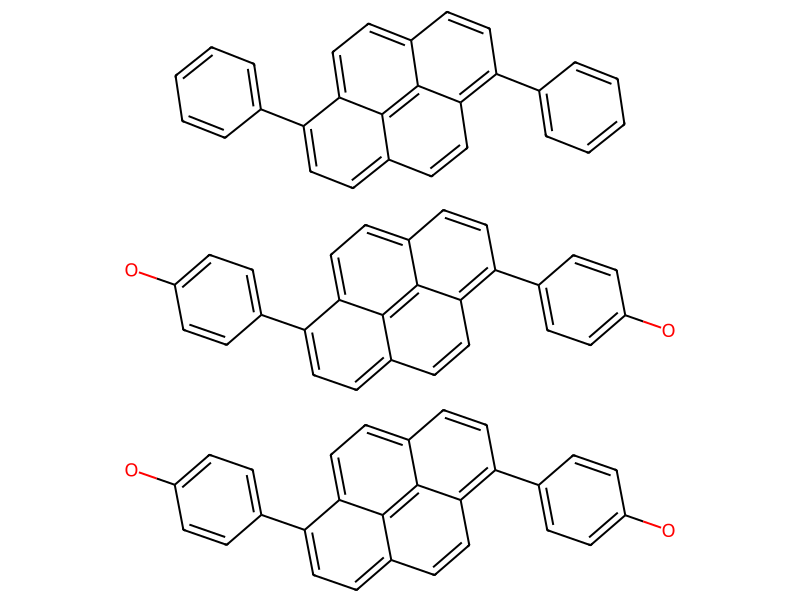

In [12]:
expanded_core0_2d = AllChem.Mol(expanded_core0)
expanded_core1_2d = AllChem.Mol(expanded_core1)
AllChem.Compute2DCoords(expanded_core0_2d)
AllChem.Compute2DCoords(expanded_core1_2d)
img=AllChem.Draw.MolsToGridImage([core2, expanded_core0_2d, expanded_core1_2d], molsPerRow=1, subImgSize=(800, 200))
img

Propose new motifs that have the same substructure as the expanded core, and align them with the extended core.

If `stretch = True`, the structure of the new motif will be fully extended.

In [13]:
nEO = 3
stretch = True
motif = util.gen_mol_from_smiles(motifB_smiles(nEO))
motif0 = util.align_to_substructure(motif, expanded_core0, stretch=stretch)
motif = util.gen_mol_from_smiles(motifB_smiles(nEO))
motif1 = util.align_to_substructure(motif, expanded_core1, stretch=stretch)

[17:12:30] combineMols: conformer id 0 not found in mol2[17:12:30] combineMols: conformer id 0 not found in mol2[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:30] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:31] Molecule does not have explicit Hs. Consider calling AddHs()
[17:12:31] Molecule does not have explicit Hs. Consider calling AddHs()


Visualize the structure of propose complex with new motifs and the receptor

In [14]:
ligand0_block = AllChem.MolToMolBlock(ligand0)
ligand1_block = AllChem.MolToMolBlock(ligand1)
motif0_block = AllChem.MolToMolBlock(motif0)
motif1_block = AllChem.MolToMolBlock(motif1)

viewer = py3Dmol.view(width=500, height=500)

viewer.addModel(ligand0_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'blue'}})
viewer.addModel(ligand1_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'blue'}})

viewer.addModel(motif0_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(motif1_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(receptor_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'green'}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Optimize the complex structure

This step will optimize the molecular structure using MMFF, while fixing the receptor as well as the substructures that match the expanded cores 

In [15]:
receptor, [motif0, motif1] = util.optimize_complex(receptor, [motif0, motif1], [expanded_core0, expanded_core1])

[17:12:31] Molecule does not have explicit Hs. Consider calling AddHs()


Visualize the optimized complex

In [16]:
ligand0_block = AllChem.MolToMolBlock(ligand0)
ligand1_block = AllChem.MolToMolBlock(ligand1)
motif0_block = AllChem.MolToMolBlock(motif0)
motif1_block = AllChem.MolToMolBlock(motif1)

viewer = py3Dmol.view(width=500, height=500)

viewer.addModel(ligand0_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'blue'}})
viewer.addModel(ligand1_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'blue'}})

viewer.addModel(motif0_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(motif1_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(receptor_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'green'}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Save the pdb file of motifs

In [17]:
motif0_h = util.add_Hs(motif0)
motif1_h = util.add_Hs(motif1)
motif0_h = util.set_resname_by_substructure(motif0_h, core2, res_name='CR', res_num=2)
motif1_h = util.set_resname_by_substructure(motif1_h, core2, res_name='CR', res_num=2)
if not os.path.exists("docking"):
    os.mkdir("docking")
util.save_pdb(motif0_h, os.path.join("docking", "motif0.pdb"))
util.save_pdb(motif1_h, os.path.join("docking", "motif1.pdb"))
util.save_pdb(motif0_h, os.path.join("docking", "motif0_nobond.pdb"), bond=False)    # save for antechamber
util.save_pdb(motif1_h, os.path.join("docking", "motif1_nobond.pdb"), bond=False)    # save for antechamber